In [ ]:
import pandas as pd
import numpy as np
import json, os, uuid
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
from tqdm import tqdm
tqdm.pandas()

from tenacity import retry, wait_random_exponential, stop_after_attempt

# Data Retrieval

In [ ]:
gm_google_reviews = pd.read_csv("./data/google_reviews.csv")

In [ ]:
google_reviews = pd.DataFrame(np.array(gm_google_reviews),columns = ['review'])
google_reviews_df = google_reviews.join(pd.DataFrame(google_reviews.pop("review").tolist()))

google_reviews_df.drop(columns = {'userImage', 'reviewCreatedVersion'}, inplace =True)
google_reviews_df.rename(columns = {'score': 'rating', 'userName' : 'user_name', "reviewId": 'review_id',
                        'content': "review_description", 'at': 'review_date', 'replyContent': 'developer_response',
                        'repliedAt' : 'developer_response_date'}, inplace = True)
google_reviews_df.insert(loc = 0 , column = "source", value = "Google Play")
google_reviews_df.insert(loc = 3 , column = "review_title", value = None)
google_reviews_df["language_code"] = 'en'
google_reviews_df["country_code"] = 'us'
google_reviews_df = google_reviews_df.drop("thumbsUpCount", axis = 1)

In [ ]:
reviews_df = pd.concat([google_reviews_df, appstore_reviews_df])
reviews_df["review_date"] = reviews_df["review_date"].apply(lambda x : str(x)[:10])
reviews_df["year"] = reviews_df["review_date"].apply(lambda x : str(x)[:4])
reviews_df["year-month"] = reviews_df["review_date"].apply(lambda x : str(x)[:7])

In [ ]:
reviews_df.head()

,Unnamed: 0,source,review_id,user_name,review_title,review_description,rating,review_date,developer_response,developer_response_date,appVersion,language_code,country_code,year,year-month
0,0,Google Play,9d9e18d7-9c64-454b-986f-27444b6330e2,abu rihan,NaN,Nc,5,2023-07-03,NaN,NaN,NaN,en,us,2023,2023-07
1,1,Google Play,17d08eef-4f68-4a44-9b09-63faf412e651,Asma Zenab,NaN,Good app,5,2023-07-03,NaN,NaN,11.8.2,en,us,2023,2023-07
2,2,Google Play,721825c7-7733-4883-88e3-5286991b6c81,Jessa Boltiador,NaN,Good,3,2023-07-03,NaN,NaN,9.64.1,en,us,2023,2023-07
3,3,Google Play,fa0dddf4-d2ca-4cd3-b456-4d98cd87ecf8,Saroja Saroja,NaN,Super app,5,2023-07-03,NaN,NaN,11.85.0300,en,us,2023,2023-07
4,4,Google Play,6f4d6ede-d138-4601-b487-468adcf0f07c,Hemlta Saxena,NaN,🛃🛃,3,2023-07-03,NaN,NaN,NaN,en,us,2023,2023-07


# Get the low rating reviews from last 3 months (2023-04 ~ 2023-06)

In [ ]:
reviews_df_2023 = reviews_df[reviews_df["year-month"].isin(['2023-04','2023-05', '2023-06'])]
reviews_df_2023_low_rate = reviews_df_2023[(reviews_df_2023["rating"] < 3) ]

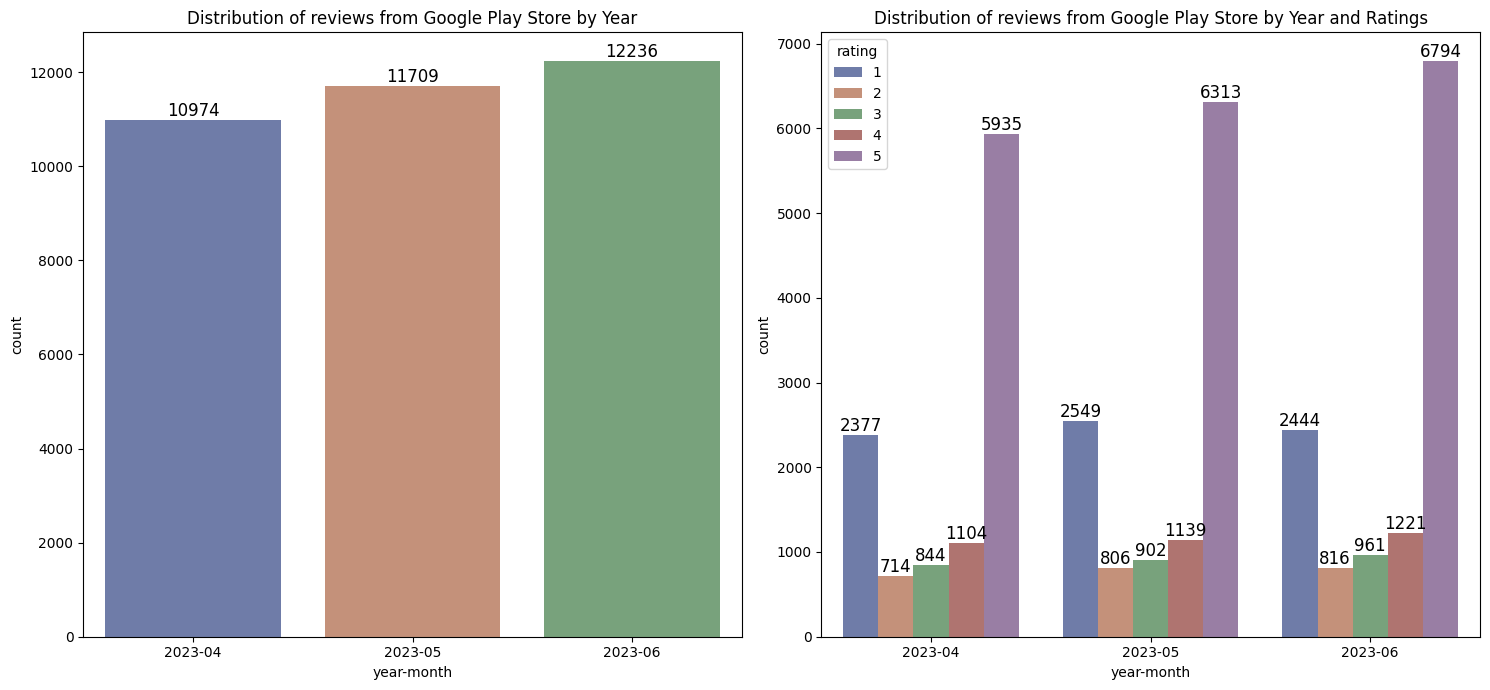

In [ ]:
plot_df = reviews_df_2023.sort_values('year', ascending=False)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))  # 1 row, 2 columns

# first plot, no hue
sns.countplot(
    data=plot_df,
    x="year-month",
    palette="dark", alpha=.6,
    order=plot_df['year-month'].sort_values(ascending=True).unique(),
    ax=axes[0]  # assign this plot to the first subplot
)

# second plot, hue = "rating"
sns.countplot(
    data=plot_df,
    x="year-month", hue="rating",
    palette="dark", alpha=.6,
    order=plot_df['year-month'].sort_values(ascending=True).unique(),
    ax=axes[1]  # assign this plot to the second subplot
)

axes[0].set_title('Distribution of reviews from Google Play Store by Year')
axes[1].set_title('Distribution of reviews from Google Play Store by Year and Ratings')

for ax in axes:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
                fontsize=12, color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Data Processing and Emdedding with GPT Model

In [ ]:
import openai
from openai.embeddings_utils import get_embedding

openai.api_key = OPEN_AI_API_KEY

In [ ]:
GPT_MODEL ="gpt-3.5-turbo"

@retry(wait=wait_random_exponential(min=1, max=40), stop=stop_after_attempt(3))
def chat_completion_request(messages, functions=None, model=GPT_MODEL):
    headers = {
        "Content-Type": "application/json",
        "Authorization": "Bearer " + openai.api_key,
    }
    json_data = {"model": model, "messages": messages, 'temperature':0}
    if functions is not None:
        json_data.update({"functions": functions})
    try:
        response = requests.post(
            "https://api.openai.com/v1/chat/completions",
            headers=headers,
            json=json_data,
        )
        return response
    except Exception as e:
        print("Unable to generate ChatCompletion response")
        print(f"Exception: {e}")
        return e


class Conversation:
    def __init__(self):
        self.conversation_history = []

    def add_message(self, role, content):
        message = {"role": role, "content": content}
        self.conversation_history.append(message)


In [ ]:
def process_chat_response(chat_response):
    try:
        text = chat_response.json()["choices"][0]['message']['content']
    except KeyError:
        print("No 'choices' in chat response, running chat_completion_request again...")
        return None

    if text == "None":
        return ["None"]
    else:
        reviews_list = text.split('\n')
        review_texts = [review.split(': ')[1] for review in reviews_list if len(review) > 0 ]
        return review_texts

def processReviews(review):
  match = re.match(r'(.*?)\s*\((\d+)', review)
  if match:
      review = match.group(1)
      number = int(match.group(2))
      review_result =  review
      number_result =  int(number)
  else:
      review_result = review
      number_result =  1

  return [review_result, number_result ]


def process_chat_response_cluster(chat_response):
    try:
        text = chat_response.json()["choices"][0]['message']['content']
    except KeyError:
        print("No 'choices' in chat response, running chat_completion_request again...")
        return None

    return text

In [ ]:
review_descriptions = reviews_df_2023_low_rate["review_description"]

# Split the list into chunks of 50 elements
chunks = [review_descriptions[i:i + 50] for i in range(0, len(review_descriptions), 50)]

# For each chunk, join the elements into a single string
# Then add each joined string to a new list
chunk_review_list = [', '.join(chunk) for chunk in chunks]

In [ ]:
bad_review_sum_ls = []

for row_num , review  in enumerate(chunk_review_list):
  conversation = Conversation()
  conversation.add_message("system",
    """This are the reviews from user. You need to summarize what are the negative experience that users mentioned in the review.
    Give me points that are negative when using the app.
    Limit each item to 20 words and consolidate similar items into a single entry.
    Organize the outcome in a numbered list format.
    Provide with number of appearance in the text on each points.
    Provide answer as following without saying anything before numbered list.

    1: First negative opinion (2 times)
    2: Second negative opinion (3 times)
    3: Third negative opinion (1 time)
    ....
    """)

  conversation.add_message("user",review)

  # chat_response = chat_completion_request(
  #       conversation.conversation_history )

  bad_points = None
  k = 0
  while bad_points is None:
    chat_response = chat_completion_request(conversation.conversation_history)
    bad_points = process_chat_response(chat_response)
    if k ==  0 :
      pass
    else :
      print(k, "th trial")
      k = k + 1

  bad_review_sum_ls.extend(bad_points)


  print(row_num , '/' , (len(chunk_review_list)-1) )

In [ ]:
review_part = [processReviews(review)[0] for review in bad_review_sum_ls]
review_freq_part = [processReviews(review)[1] for review in bad_review_sum_ls]

n_review_df = pd.DataFrame({'review':review_part, "number" : review_freq_part })

In [ ]:
embedding_model = "text-embedding-ada-002"

n_review_df["review_embedding"] = n_review_df["review"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))


# Clustering Google Maps App Reviews

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
matrix = np.vstack(n_review_df.review_embedding.values)
n_clusters = 100

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=10)
kmeans.fit(matrix)
n_review_df['cluster'] = kmeans.labels_

# Evaluating and Adjusting Clustering with GPT Model

In [ ]:
cluster_set = set(n_review_df["cluster"] )
cluster_st_dict = {}

for row_num , cluster in enumerate(cluster_set):
    tmp_df = n_review_df[n_review_df["cluster"] == cluster]

    text = 'These are the bad review of app \n '
    for r, n in enumerate(tmp_df["review"]):
        text = text + f"Review {str(r+1)}: {n} \n "


    conversation = Conversation()
    conversation.add_message("system",
    """Assume you are working at a company and that you are given task to summarizing the reviews.
    These are the bad comments from the reviews across multiple reviews.
    Give summarization of bad comments in these reviews.
    Limit the answer to 20 words and just state the summrization without saying unrelavant thing such as "The bad comments from the reviews" or "Summary:" .""")

    conversation.add_message("user",text )

    chat_response = chat_completion_request(
        conversation.conversation_history )

    bad_points = None
    k = 0
    while bad_points is None:
      chat_response = chat_completion_request(conversation.conversation_history)
      bad_points = process_chat_response_cluster(chat_response)
      if k ==  0 :
        pass
      else :
        print(k, "th trial")
        k = k + 1


    cluster_st_dict.update({cluster : bad_points })

    print(row_num , '/' , (len(cluster_set)-1) )

In [ ]:
cluster_text = "Categorize clusters that exhibit similarities in the explanation based on the provided inforamtion on each cluster. \n\n"
for x in range(50) :
    cluster_text =  cluster_text + f"Cluster {x} : {cluster_st_dict[x]} \n"

cluster_text2 = "Categorize clusters that exhibit similarities in the explanation based on the provided inforamtion on each cluster. \n\n"
for x in range(50) :
    cluster_text2 =  cluster_text2 + f"Cluster {x+50} : {cluster_st_dict[x+50]} \n"


conversation = Conversation()
conversation.add_message("system",
"""This is the 50 different cluster with explanation to each of the cluster. List out which cluster number belongs newly defined cluster you created with breif summary""")
conversation.add_message("user",cluster_text  )

chat_response = chat_completion_request(
    conversation.conversation_history )


cluster_text2 = "Summarize clusters based on the provided inforamtion on each cluster. \n\n"
for x in range(50) :
    cluster_text2 =  cluster_text2 + f"Cluster {x+50} : {cluster_st_dict[x+50]} \n"

conversation = Conversation()
conversation.add_message("system",
"""This is the 50 different cluster with explanation to each of the cluster. provide each cluster with breif summary""")
conversation.add_message("user",cluster_text2  )

chat_response2 = chat_completion_request(
    conversation.conversation_history )

In [ ]:
new_cluster_dict = {}
cluster_part_1 = text1.split("\n\n")[1]


for line in cluster_part_1.split('\n'):
    match = re.match(r'Cluster (\d+): (.*)', line)
    if match:
        new_cluster_dict[int(match.group(1))] = match.group(2)

for line in text2.split("\n\n")[1:]:
  line = line.replace("Newly defined cluster: \n- ","")
  match = re.match(r'Cluster (\d+): (.*)', line)
  if match:
        new_cluster_dict[int(match.group(1))] = match.group(2)

In [ ]:
new_cluster_dict

{0: 'Battery and performance issues',
 1: 'GPS tracking issues',
 2: 'Routing and navigation issues',
 3: 'AI and stability issues',
 4: 'App responsiveness and map display issues',
 5: 'GPS searching and performance issues',
 6: 'Changes in features and navigation difficulties',
 7: 'Incorrect directions and maps',
 8: 'Voice command and navigation issues',
 9: 'Poor GPS functionality',
 10: 'Location sharing difficulties',
 11: 'Slow performance and loading times',
 12: 'App crashes and freezes',
 13: 'Inconsistent and inaccurate route suggestions',
 14: 'Poor functionality and lack of useful information',
 15: 'Compatibility and device issues',
 16: 'Issues with transport options and trip planning',
 17: 'Audio quality issues',
 18: 'App opening and uninstalling issues',
 19: 'Dark mode control issues',
 20: 'Inaccurate and slow route display',
 21: 'Incorrect locations and travel information',
 22: 'Satellite view and imagery issues',
 23: 'Outdated and missing map information',
 2

# Re-grouped 100 clusters down to 40 clusters manually

In [ ]:
df_regroup = pd.read_csv('file')
df = reviews_df_2023_low_rate.copy()

gp_ls = set(df_regroup["Re-group"])
cluster_df = pd.DataFrame({"Cluster Summary" : list(gp_ls) , "Cluster" : list(range(40))})

In [ ]:
cluster_df

,Cluster Summary,Cluster
0,"Slow loading, faulty search, excessive resourc...",0
1,Battery drain and performance issues,1
2,Speed Limit related Issue,2
3,Lack of road information and traffic alerts,3
4,Poor customer support and lack of response,4
5,Location related Issues,5
6,Issues with audio,6
7,Difficulty adding and editing information,7
8,Difficulty in inputting and displaying accurat...,8
9,Issue with search,9


In [ ]:
cluster_df["Cluster_embedding"] = cluster_df["Cluster Summary"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))

100%|██████████| 40/40 [00:11<00:00,  3.39it/s]


In [ ]:
df["review_description_embedding"] = df["review_description"].progress_apply(lambda x: get_embedding(x, engine=embedding_model))

100%|██████████| 9706/9706 [21:24<00:00,  7.56it/s]


In [ ]:
def get_distances_embedding(embedding, cluster_df) :
    vec = np.array(embedding)
    list_vec = np.array(list(cluster_df["Cluster_embedding"]) )

    distances = np.linalg.norm(list_vec - vec, axis=1)
    index = np.argmin(distances)

    return index

In [ ]:
df["cluster"] = df["review_description_embedding"].progress_apply(lambda x:get_distances_embedding(x, cluster_df) )

100%|██████████| 9706/9706 [01:10<00:00, 137.21it/s]


In [ ]:
df = df.merge(cluster_df, 'left', left_on =  "cluster", right_on = "Cluster")

## Summary of Negative reviews of Google Maps App

In [ ]:
df_summary = (df[["review_id", "Cluster", "Cluster Summary"]].groupby(["Cluster", "Cluster Summary"])
.count()
.reset_index()
.sort_values("review_id", ascending=False)
)

df_summary.rename(columns={"review_id": "Count"}, inplace=True)
df_summary

,Cluster,Cluster Summary,Count
39,39,Unreliable information,1290
19,19,Issues with bus tracking and directions,1058
3,3,Difficult navigation and poor design,671
1,1,Problems with loading and displaying maps,667
30,30,App malfunctions and connectivity issues,517
25,25,Lack of road information and traffic alerts,482
10,10,Issue with search,407
14,14,Outdated and unstable satellite and street view,352
34,34,Difficulty in inputting and displaying accurat...,335
16,16,Location related Issues,284


## Looking into eviews related to Saved place in Google Maps

In [ ]:
saved_place_df = df[df["Cluster"] == 18]

In [ ]:
output1 = ""
for n , text in enumerate(saved_place_df["review_description"][:136]):
  output1 += f'Reivew {n+1} : {text}\n '


output2 = ""
for n , text in enumerate(saved_place_df["review_description"][136:]):
  output2 += f'Reivew {n+1} : {text}\n '


conversation = Conversation()
conversation.add_message("system",
  """When user gives you the reivew, summarize the reviews in numbered list.""")

conversation.add_message("user",output1)

# chat_response = chat_completion_request(
#       conversation.conversation_history )

chat_response = chat_completion_request(conversation.conversation_history, model = "gpt-4")


conversation = Conversation()
conversation.add_message("system",
  """When user gives you the reivew, summarize the reviews in numbered list.""")

conversation.add_message("user",output2)

# chat_response = chat_completion_request(
#       conversation.conversation_history )

chat_response2 = chat_completion_request(conversation.conversation_history, model = "gpt-4")


In [ ]:
summary_1 = chat_response.json()["choices"][0]['message']['content']
summary_2 = chat_response2.json()["choices"][0]['message']['content']

## Review summary related to Saved-place

1. Users want the "I haven't been there" option back when asked for reviews.
2. Some users lost all their saved places after an update.
3. Users find it hard to pull up saved places due to lack of search or sorting options.
4. Users report issues with saved places showing as coordinates instead of names.
5. Users report issues with downloading saved places.
6. Users report issues with saved locations not coming up in the search bar.
7. Users can't set more than one workplace or create shortcuts to other saved places.
8. Users are frustrated with the handling of saved places, which often don't show up on the map.
9. Users are upset about the disappearance of saved locations and the inability to view all saved places on the "explore" page.
10. Users are upset about the app's inability to continuously share location with people they've allowed to see.
11. Users are frustrated with the app's inability to use different icons for different saved places lists.
12. Users are frustrated with the app's inability to save places in lists or view the list of marked places.



## Looking into eviews related to reivews in Google Maps

In [ ]:
review_df = df[df["Cluster"] == 24]

In [ ]:
output3 = ""
for n , text in enumerate(review_df["review_description"][:133]):
  output3 += f'Reivew {n+1} : {text}\n '


output4 = ""
for n , text in enumerate(review_df["review_description"][133:]):
  output4 += f'Reivew {n+1} : {text}\n '


conversation = Conversation()
conversation.add_message("system",
  """When user gives you the reivew, summarize the reviews in numbered list.""")

conversation.add_message("user",output3)

# chat_response = chat_completion_request(
#       conversation.conversation_history )

chat_respons3 = chat_completion_request(conversation.conversation_history)


conversation = Conversation()
conversation.add_message("system",
  """When user gives you the reivew, summarize the reviews in numbered list.""")

conversation.add_message("user",output4)

# chat_response = chat_completion_request(
#       conversation.conversation_history )

chat_response4 = chat_completion_request(conversation.conversation_history)

In [ ]:
summary_3 = chat_respons3.json()["choices"][0]['message']['content']
summary_4 = chat_response4.json()["choices"][0]['message']['content']

## Review summary related to reviews

1. Some users have expressed frustration over the inability to post negative reviews or have their negative reviews removed.
2. A few users have expressed dissatisfaction with the review system, claiming that it favors businesses over users.
3. Some users have reported that their reviews have been deleted without their consent.
